<a href="https://colab.research.google.com/github/dduwa/ocular-disease-recognition/blob/main/Resnet50_ODIR5K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
import os

from concurrent.futures import ThreadPoolExecutor

from ast import literal_eval
from sklearn.model_selection import train_test_split
from keras.layers import Dropout


# Access Dataset via Kaggle API
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem.

In [2]:
from google.colab import files
uploaded = files.upload()

!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip -q ocular-disease-recognition-odir5k.zip

Saving kaggle.json to kaggle.json
100% 1.62G/1.62G [01:13<00:00, 20.7MB/s]
100% 1.62G/1.62G [01:13<00:00, 23.7MB/s]


# Loading the Dataset

In [3]:
df_data = pd.read_csv('full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Dataset Information

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

# Preparing the Data

In [5]:
# Convert the string representation of one-hot encoded vectors to lists
df_data['target_list'] = df_data['target'].apply(literal_eval)

# Get the index of the '1' in each list which represents the class label
df_data['class_label'] = df_data['target_list'].apply(lambda x: np.argmax(x))

# Now you can use these class labels for stratified sampling
train_df, test_df = train_test_split(
    df_data,
    test_size=0.2,
    random_state=123,
    stratify=df_data['class_label']  # Use the class labels for stratification
)

# Do the same for splitting the training set into training and validation sets
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=123,
    stratify=train_df['class_label']  # Use the class labels for stratification
)

In [6]:
def file_exists(file_paths):
    # Filter out non-existing files
    return [file_path for file_path in file_paths if os.path.exists(file_path)]

def load_and_prepare_dataset(df, images_dir, shuffle=True, batch_size=32):
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']

    labels_left = df['target'].values
    labels_right = df['target'].values

    # Combine the left and right images and labels
    filenames = np.concatenate([images_left, images_right])
    labels = np.concatenate([labels_left, labels_right])

    # Filter out filenames that do not exist
    valid_filenames = file_exists(filenames)
    valid_labels = labels[np.isin(filenames, valid_filenames)]  # Keep labels corresponding to the valid filenames

    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((valid_filenames, valid_labels))
    dataset = dataset.map(parse_image_and_label)  # Apply the preprocessing function
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(valid_filenames))
    dataset = dataset.batch(batch_size)
    return dataset

def parse_image_and_label(image_path, label_string):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2)
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)
    return image, label


In [50]:
train_ds = load_and_prepare_dataset(train_df, 'preprocessed_images/', shuffle=True, batch_size=64)
val_ds = load_and_prepare_dataset(val_df, 'preprocessed_images/', shuffle=False, batch_size=64)
test_ds = load_and_prepare_dataset(test_df, 'preprocessed_images/', shuffle=False, batch_size=64)

In [51]:
print("size of training dataset: ", len(train_ds))
print("size of validation dataset: ", len(val_ds))
print("size of test dataset: ", len(test_ds))

size of training dataset:  125
size of validation dataset:  32
size of test dataset:  39


# Visualising the training and validation datasets




Training dataset
(32, 224, 224, 3)
(32, 8)


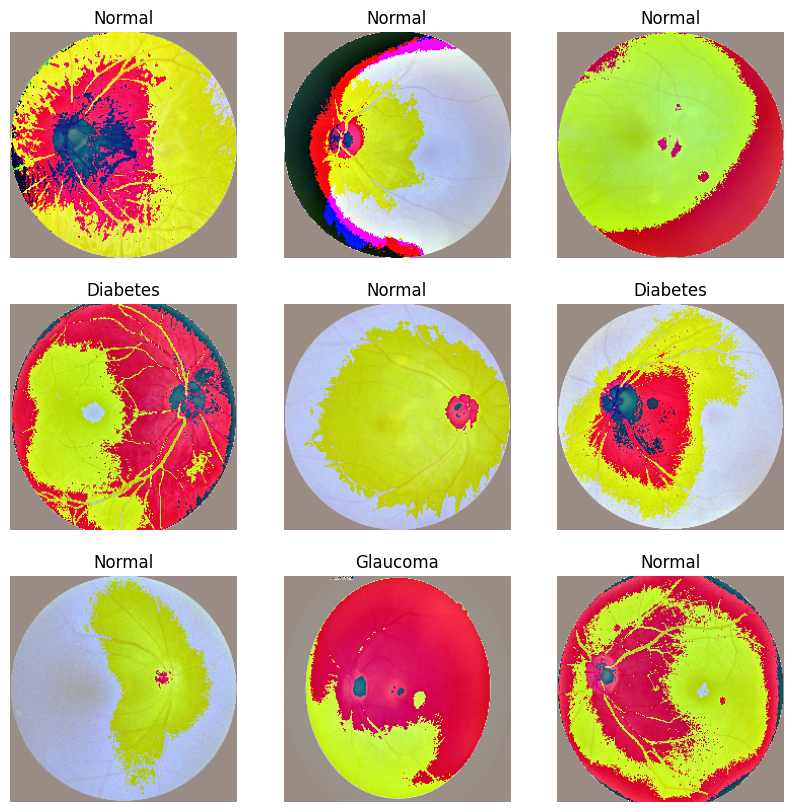

In [9]:
print("Training dataset")
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])

    plt.axis("off")


Validation dataset
(32, 224, 224, 3)
(32, 8)


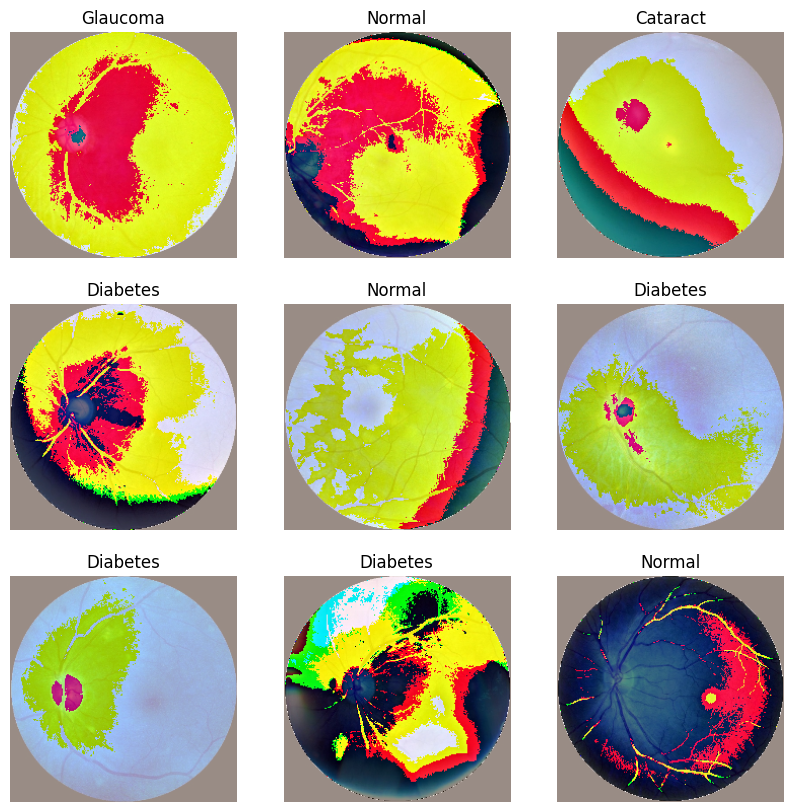

In [10]:
print("Validation dataset")
for images, labels in val_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])
    plt.axis("off")

In [11]:
# Calculate class weights
def get_class_weights(labels):
    total_samples = len(labels)
    n_classes = len(labels[0])
    class_counts = np.zeros(n_classes)
    for label in labels:
        class_counts += label
    class_weights = total_samples / (n_classes * class_counts)
    return class_weights

# Get the labels from the training dataset
train_labels = []
for _, labels in train_ds:
    train_labels.append(labels.numpy())
train_labels = np.concatenate(train_labels)

# Assuming class_weights is the array returned by your function
class_weights_array = get_class_weights(train_labels)

# Convert this array into a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class weights dictionary:", class_weights_dict)

Class weights dictionary: {0: 0.27916899832120873, 1: 0.4949156746031746, 2: 2.7870111731843576, 3: 2.7335616438356163, 4: 2.978358208955224, 5: 6.158950617283951, 6: 3.5008771929824563, 7: 1.124859075535513}


# Training the model

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [13]:
checkpoint = ModelCheckpoint(filepath='best_model_Resnet50.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1) # increased patience from 3 to 5 and factor from 0.2 to 0.5
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # increased from 5 to 10


callbacks = [early_stopping, checkpoint, reduce_lr]

In [14]:
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_50_model = Sequential()

resnet_50_model.add(pretrained_model)
resnet_50_model.add(Flatten())
#resnet_50_model.add((Dense(256, activation='relu')))
resnet_50_model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
resnet_50_model.add(Dropout(0.5))
resnet_50_model.add(Dense(8, activation='softmax'))

94765736/94765736 [==============================] - 5s 0us/step


In [15]:
resnet_50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 24114312 (91.99 MB)
Trainable params: 526600 (2.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [16]:
resnet_50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
epochs = 50
history = resnet_50_model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, class_weight=class_weights_dict)

Epoch 1/50
250/250 [==============================] - ETA: 0s - loss: 2.2967 - accuracy: 0.2073
Epoch 1: val_loss improved from inf to 2.11192, saving model to best_model_Resnet50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 25s 42ms/step - loss: 2.2967 - accuracy: 0.2073 - val_loss: 2.1119 - val_accuracy: 0.3020 - lr: 1.0000e-04
Epoch 2/50
249/250 [============================>.] - ETA: 0s - loss: 1.9132 - accuracy: 0.2710
Epoch 2: val_loss improved from 2.11192 to 1.95932, saving model to best_model_Resnet50.h5
250/250 [==============================] - 13s 33ms/step - loss: 1.9125 - accuracy: 0.2709 - val_loss: 1.9593 - val_accuracy: 0.3889 - lr: 1.0000e-04
Epoch 3/50
249/250 [============================>.] - ETA: 0s - loss: 1.7878 - accuracy: 0.3084
Epoch 3: val_loss did not improve from 1.95932
250/250 [==============================] - 13s 31ms/step - loss: 1.7867 - accuracy: 0.3084 - val_loss: 2.0103 - val_accuracy: 0.3342 - lr: 1.0000e-04
Epoch 4/50
248/250 [============================>.] - ETA: 0s - loss: 1.7199 - accuracy: 0.3304
Epoch 4: val_loss improved from 1.95932 to 1.91380, saving model to best_model_Resnet50.h5
250/250 [========================

# Evaluating Model
- Model Accuracy
- Model Loss


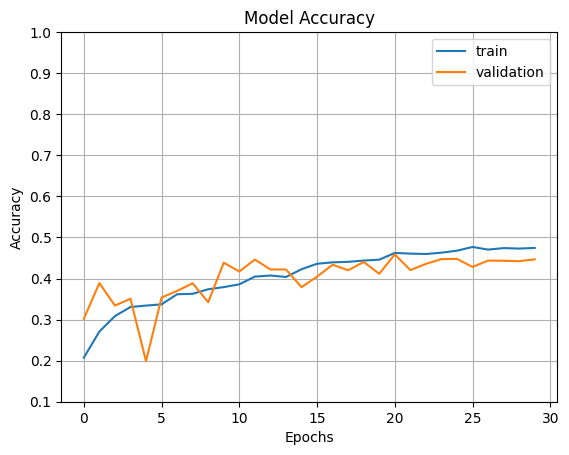

In [34]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

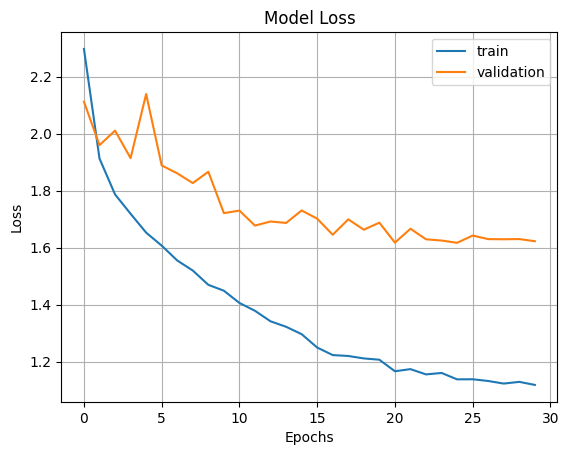

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions

In [36]:
test_ds.take(1)

# Evaluating the model on the test set
loss, accuracy = resnet_50_model.evaluate(test_ds)
print(f'Test accuracy: {round(accuracy * 100, 2)}%')

78/78 [==============================] - 2s 22ms/step - loss: 1.5997 - accuracy: 0.4538
Test accuracy: 45.38%


78/78 [==============================] - 2s 22ms/step - loss: 1.5997 - accuracy: 0.4538
Evaluation results: [1.599705696105957, 0.45377814769744873]
78/78 [==============================] - 2s 20ms/step


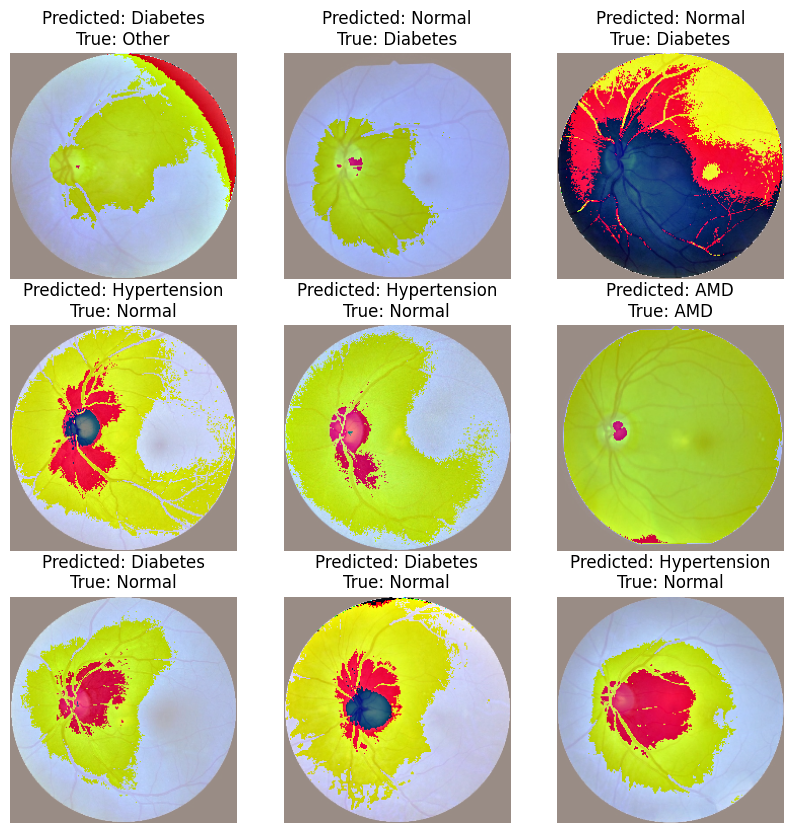

In [37]:
# Evaluate the model on the test dataset
evaluation_results = resnet_50_model.evaluate(test_ds)
print("Evaluation results:", evaluation_results)

# Generate predictions
predictions = resnet_50_model.predict(test_ds)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Define the number of images you want to display
num_images_to_display = 9

# Initialize lists to store the images and labels
display_images = []
display_labels = []

# Iterate over the dataset to collect images and labels
for images, labels in test_ds.unbatch().take(num_images_to_display):
    display_images.append(images)
    display_labels.append(labels)

# Now plot the images with predictions and true labels
plt.figure(figsize=(10, 10))
for i, image in enumerate(display_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    true_label = class_labels[np.argmax(display_labels[i].numpy())]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()

# Evaluating Predictions

In [38]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report

In [39]:
for _, label in test_ds.unbatch().take(1):
    print("Unbatched label shape:", label.numpy().shape)
# Collect the true labels from the unbatched dataset
true_labels = np.vstack([y.numpy() for _, y in test_ds.unbatch()])

# true_labels should now be a 2-dimensional array, you can verify by printing its shape
print("Shape of true_labels after vstack:", true_labels.shape)

# Convert one-hot encoded labels to class indices
true_classes = np.argmax(true_labels, axis=1)

Unbatched label shape: (8,)
Shape of true_labels after vstack: (2488, 8)


In [40]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)

                precision    recall  f1-score   support

        Normal       0.67      0.39      0.49      1121
      Diabetes       0.47      0.46      0.47       626
      Glaucoma       0.33      0.74      0.45       111
      Cataract       0.52      0.86      0.65       115
           AMD       0.40      0.58      0.47       106
  Hypertension       0.12      0.46      0.20        50
        Myopia       0.63      0.94      0.75        82
Other diseases       0.19      0.21      0.20       277

      accuracy                           0.45      2488
     macro avg       0.42      0.58      0.46      2488
  weighted avg       0.52      0.45      0.46      2488



 Balanced Accuracy Score

In [41]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Balanced Accuracy: 0.5800


Area Under the Reciever Operating Characteristic Curve (AUC-ROC)


In [42]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.8331


Confusion Matrix

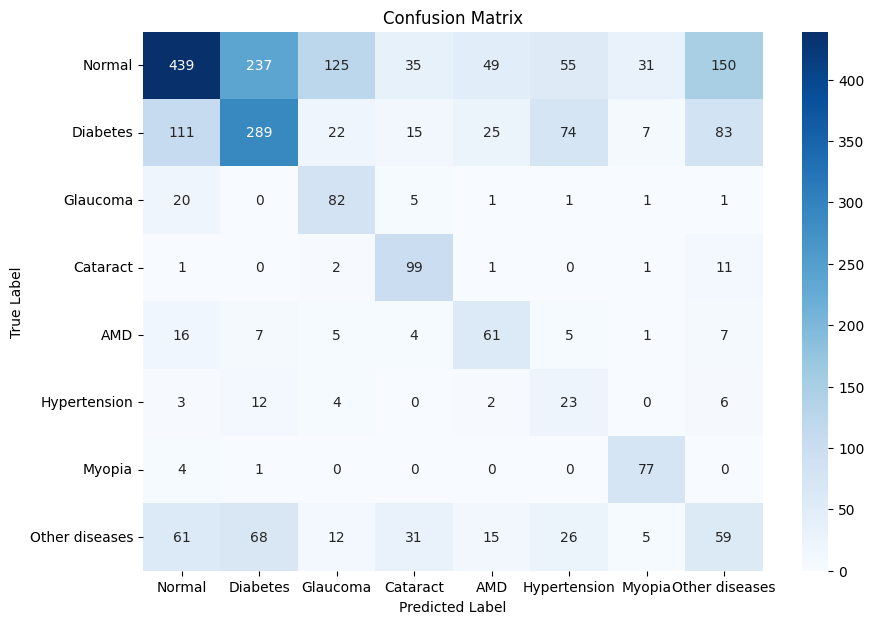

In [43]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Frequency of each class in top 3 predictions across all images


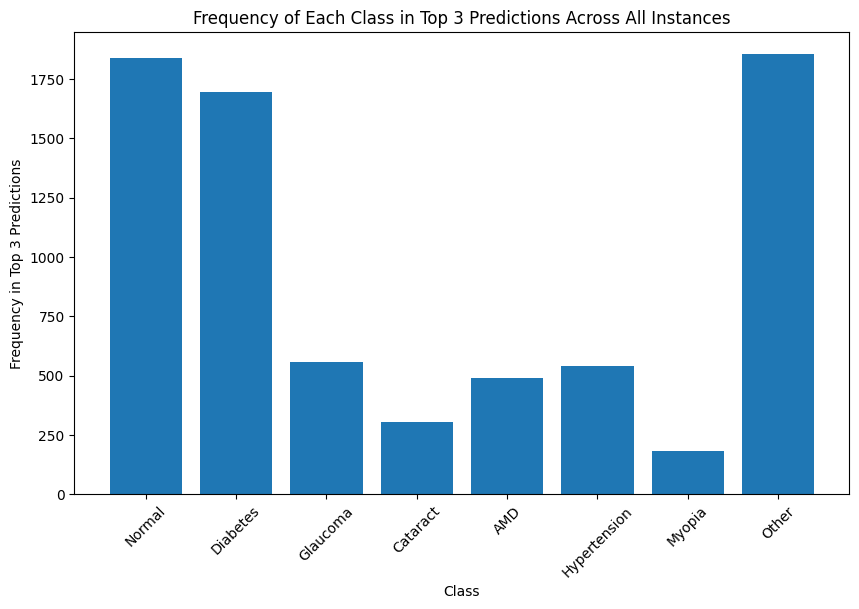

In [44]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1



# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()

# Explainable AI - SHAP, GradCAM and LIME

SHAP

---



In [45]:
!pip install shap

In [46]:
import shap

In [47]:
masker =  shap.maskers.Image("inpaint_telea", (224, 224, 3))
explainer = shap.Explainer(resnet_50_model, masker=masker)


In [48]:

# Step 1: Unbatch the dataset and process both images and labels
unbatched_images = np.stack([x.numpy() for x, _ in test_ds.unbatch()])
true_labels = np.vstack([y.numpy() for _, y in test_ds.unbatch()])

# Verify shapes
print("Shape of unbatched_images:", unbatched_images.shape)
print("Shape of true_labels after vstack:", true_labels.shape)

# Convert one-hot encoded labels to class indices
true_classes = np.argmax(true_labels, axis=1)

# Normalize images for visualization (convert range from [-1, 1] or any preprocessing range back to [0, 255])
# This step assumes images were normalized in a way that's reversible to the [0, 255] range
images_for_visualization = ((unbatched_images - unbatched_images.min()) / (unbatched_images.max() - unbatched_images.min()) * 255).astype(np.uint8)

# Step 2: Compute SHAP values for a subset or individual samples
num_samples_to_explain = 10  # For example, explaining 10 samples
shap_values_list = []

for i in range(num_samples_to_explain):
    # Extract the i-th image data for explanation
    image_to_explain = unbatched_images[i:i+1]  # Keep the batch dimension for compatibility

    # Compute SHAP values for this image
    shap_values = explainer(image_to_explain)

    # Store the SHAP values
    shap_values_list.append(shap_values)

    # Normalize the specific image for visualization
    image_for_vis = images_for_visualization[i]

    # Visualize the SHAP values for this sample
    # Ensure the image data is in the expected range ([0, 255] for integers) and shape for `shap.image_plot`
    shap.image_plot(shap_values, image_for_vis)

Shape of unbatched_images: (2488, 224, 224, 3)
Shape of true_labels after vstack: (2488, 8)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.16s/it]               


IndexError: index 1 is out of bounds for axis 1 with size 1

Error in callback <function flush_figures at 0x79703240c280> (for post_execute):


KeyboardInterrupt: 

In [49]:
# Step 1: Unbatch the dataset and process both images and labels
unbatched_images = np.stack([x.numpy() for x, _ in test_ds.unbatch()])
true_labels = np.vstack([y.numpy() for _, y in test_ds.unbatch()])

# Verify shapes
print("Shape of unbatched_images:", unbatched_images.shape)
print("Shape of true_labels after vstack:", true_labels.shape)

# Convert one-hot encoded labels to class indices (you've already done this)
true_classes = np.argmax(true_labels, axis=1)

# Step 2: Compute SHAP values for a subset or individual samples
# Note: Depending on the size of your data and model complexity, you may want to limit the number of samples
num_samples_to_explain = 10  # For example, explaining 10 samples

# Initialize a list to hold SHAP values for the chosen samples
shap_values_list = []



Shape of unbatched_images: (2488, 224, 224, 3)
Shape of true_labels after vstack: (2488, 8)


In [ ]:
for i in range(num_samples_to_explain):
    # Extract the i-th image data for explanation
    image_to_explain = unbatched_images[i:i+1]  # Keep the batch dimension for compatibility

    # Compute SHAP values for this image
    shap_values = explainer(image_to_explain)

    # Store the SHAP values
    shap_values_list.append(shap_values)

    # Optionally, visualize the SHAP values for this sample
    shap.image_plot(shap_values, -image_to_explain)